<a href="https://colab.research.google.com/github/K7chyp/msft_time_series/blob/main/msft_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# !pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

import yfinance as yf


In [5]:
df_msft = yf.download('MSFT',
                    period = 'max',
                    interval = '1d',
                    progress=True)


[*********************100%***********************]  1 of 1 completed


In [6]:
df_msft

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400
...,...,...,...,...,...,...
2021-02-12,243.929993,245.300003,242.729996,244.990005,244.427048,16552000
2021-02-16,245.029999,246.130005,242.919998,243.699997,243.139999,26708200
2021-02-17,241.320007,244.309998,240.940002,244.199997,244.199997,21653500


In [84]:
class Metrics:

    def __init__(self, dataframe):
        self.dataframe = dataframe.copy()

    def get_min_max(self, column):
        return min(self.dataframe[column].to_list()), max(
            self.dataframe[column].to_list()
        )

    def get_average(self, column):
        sum_ = 0
        for value in self.dataframe[column]:
            sum_ = value
        return sum_ / len(self.dataframe)

    def more_less_avg(self, column):

        avg = self.get_average(column)
        more_than_avg = 0
        less_than_avg = 0

        for value in self.dataframe[column].to_list():
            if value >= avg:
                more_than_avg += 1
            else:
                less_than_avg += 1

        return more_than_avg, less_than_avg
    
    def get_mode(self, column):

        mode_ = max(
            set(self.dataframe[column].to_list()),
            key=self.dataframe[column].to_list().count,
        )

        return mode_

    def get_stat(self, column):

        min_, max_ = self.get_min_max(column)
        avg_ = self.get_average(column)
        mta, lta = self.more_less_avg(column)
        mode_ = self.get_mode(column)

        return print(
            f"Minimum {min_}",
            f"Maximum {max_}",
            f"Average {avg_}",
            f"Mode {mode_} ",
            f"More than average {mta}",
            f"Less than averange {lta} ",
            sep="\n",
        )


In [85]:
metrics = Metrics(df_msft)
metrics.get_stat('Low')

Minimum 0.08854199945926666
Maximum 242.9199981689453
Average 0.02727148775698663
Mode 25.5 
More than average 8807
Less than averange 0 


In [91]:
class Errors():

  @staticmethod
  def mae(y_pred, y_true):
    return np.average(np.average(np.abs(y_pred - y_true), axis=0))

In [96]:
class Preprocessing():

  def  __init__(self, dataframe): 
    self.dataframe = dataframe.copy()
  
  def weighted_average(self, column, weights):
    result = 0.0
    weights.reverse()
    series = self.dataframe[column]
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result) 
  
  def exponential_smoothing(self, column, alpha):
    series = self.dataframe[column]
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


In [90]:
preproc = Preprocessing(df_msft[-100::])
preproc.weighted_average('Low', [0.6, 0.3, 0.1] )

240.84000091552736

In [99]:
class Visualisation(Metrics, Preprocessing, Errors):
  
    def plot_more_less_avg(self):

        more_than_avg, less_than_avg = self.more_less_avg()

        labels = ["More than average", "Less than average"]
        values = [more_than_avg, less_than_avg]

        fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

        return fig.show()

    def plot_hist(self, column):
        plt.hist(self.dataframe[column], 5, color="Blue")
        plt.title(column)
        return plt.show()

    def plot_common_hist(self):
        for column in self.dataframe.columns.to_list():
            self.plot_hist(column)

    def plot_graphs(self):

        for column in self.dataframe.columns.to_list():
            plt.plot(self.dataframe[column])
            plt.ylabel(column)
            plt.show()

    def plot_moving_average(self, column,
                            window, plot_intervals=False, 
                            scale=1.96):

      rolling_mean = self.dataframe[column].rolling(window=window).mean()
      series = self.dataframe[column]
      plt.figure(figsize=(15,5))

      plt.title("Moving average\n window size = {}".format(window))
      plt.plot(rolling_mean, "g", label="Rolling mean trend")

      # Plot confidence intervals for smoothed values
      if plot_intervals:
          mae =self.mae(series[window:], rolling_mean[window:])
          deviation = np.std(series[window:] - rolling_mean[window:])
          lower_bond = rolling_mean - (mae + scale * deviation)
          upper_bond = rolling_mean + (mae + scale * deviation)
          plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
          plt.plot(lower_bond, "r--")
          
      plt.plot(series[window:], label="Actual values")
      plt.legend(loc="upper left")
      plt.grid(True)
    
    def plot_exponential_smoothing(self, column, alphas):

      series = self.dataframe[column]
      with plt.style.context('seaborn-white'):    
          plt.figure(figsize=(15, 7))
          for alpha in alphas:
              plt.plot(self.exponential_smoothing(column, alpha), 
                       label="Alpha {}".format(alpha))
          plt.plot(series.values, "c", label = "Actual")
          plt.legend(loc="best")
          plt.axis('tight')
          plt.title("Exponential Smoothing")
          plt.grid(True);

     

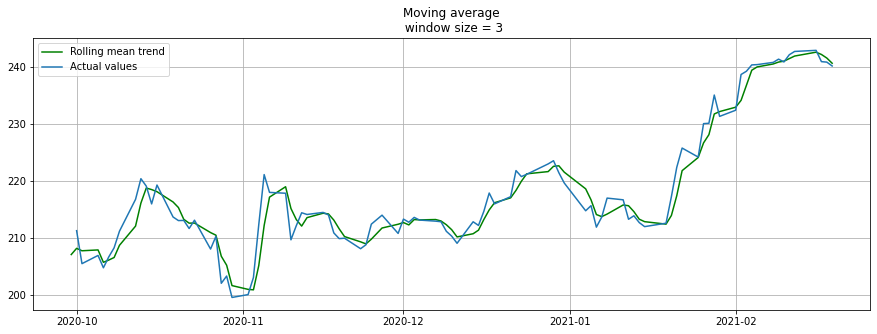

In [93]:
vis = Visualisation(df_msft[-100::])
vis.plot_moving_average('Low', 3)

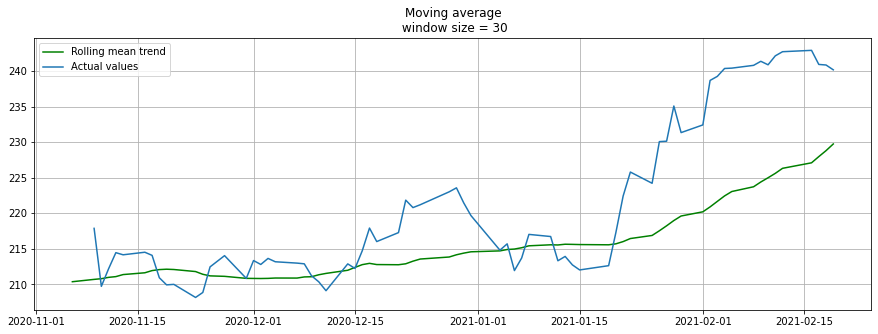

In [94]:
vis = Visualisation(df_msft[-100::])
vis.plot_moving_average('Low', 30)

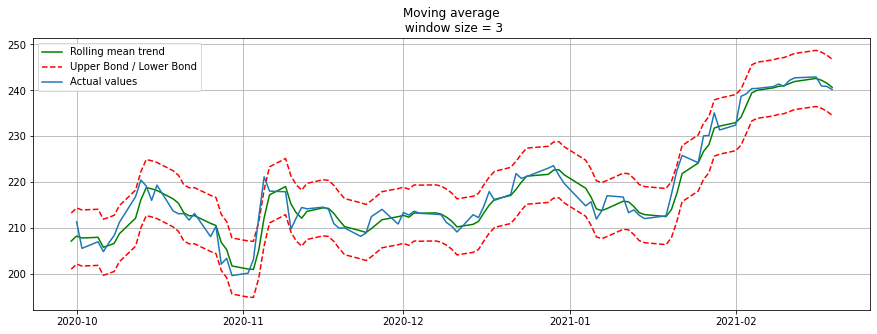

In [95]:
vis = Visualisation(df_msft[-100::])
vis.plot_moving_average('Low', 3, plot_intervals=True)

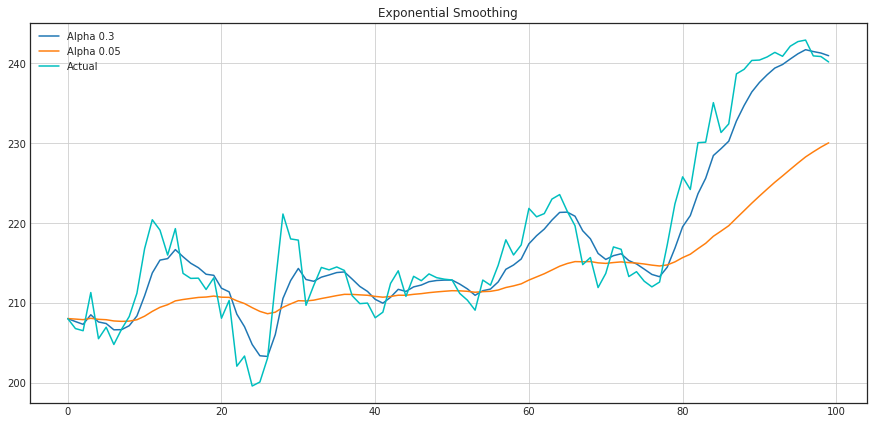

In [100]:
vis = Visualisation(df_msft[-100::])
vis.plot_exponential_smoothing('Low',[0.3, 0.05])